In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import json

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
from torchvision import datasets

# RNN Classifier 实现

实现目标: 将名字分类为不同的国家

## 数据集

来源: [Github](https://github.com/d4em0n/nationality-classify)

In [2]:
HIDDEN_SIZE = 100
BATCH_SIZE = 256
N_LAYER = 2
N_EPOCH = 100
N_CHARS = 128
USE_GPU = torch.cuda.is_available()

## Prepare Dataset

In [3]:
class NameDataset(Dataset):
    def __init__(self, csv_file):
        with open(csv_file, 'r') as f:
            reader = csv.reader(f)
            rows = list(reader)
        
        self.names = [row[0] for row in rows[1:]]
        self.countries = [int(row[1]) for row in rows[1:]]
        self.len = len(self.names)

        with open('./dataset/name2country/country.json', 'r') as f:
            self.country_list = json.load(f)
        self.country_num = len(self.country_list)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.names[idx], self.countries[idx]
    
    def idx2country(self, idx):
        return self.country_list[idx]
    
train_dataset = NameDataset('./dataset/name2country/train.csv')
test_dataset = NameDataset('./dataset/name2country/test.csv')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

N_COUNTRIES = train_dataset.country_num

## Design Model

In [4]:
def time_since(since):
    period = time.time() - since
    minutes = int(period / 60)
    seconds = int(period - minutes * 60)
    return '{:3d}m {:2d}s'.format(minutes, seconds)

def create_tensor(tensor):
    if USE_GPU:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        tensor = tensor.to(device)
    return tensor

def name2list(name):
    return [ord(ch) for ch in name], len(name)

def make_tensors(names, countries):
    sequences_and_lengths = [name2list(name) for name in names]
    name_sequences = [s[0] for s in sequences_and_lengths]
    seq_lengths = torch.LongTensor([s[1] for s in sequences_and_lengths])
    countries = countries.long()

    seq_tensor = torch.zeros(len(name_sequences), max(seq_lengths)).long()
    for idx, (seq, seq_len) in enumerate(sequences_and_lengths):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
    seq_tensor = seq_tensor[perm_idx]
    countries = countries[perm_idx]

    return create_tensor(seq_tensor), create_tensor(seq_lengths), create_tensor(countries)

class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = 2 if bidirectional else 1

        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=bidirectional)
        self.fc = torch.nn.Linear(hidden_size * self.n_directions, output_size)
    
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_size)
        return create_tensor(hidden)
    
    def forward(self, input, seq_lengths):
        input = input.t()
        batch_size = input.size(1)

        hidden = self._init_hidden(batch_size)
        embedding = self.embedding(input)

        gru_input = pack_padded_sequence(embedding, seq_lengths.cpu())      # 注意这个函数的 `lengths` 参数只接受 CPU 张量
        output, hidden = self.gru(gru_input, hidden)

        if self.n_directions == 2:
            hidden_cat = torch.cat((hidden[-1], hidden[-2]), dim=1)
        else:
            hidden_cat = hidden[-1]
        
        return self.fc(hidden_cat)

## Train & Test

In [5]:
def train_model():
    total_loss = 0
    for i, (names, countries) in enumerate(train_loader, 1):
        inputs, seq_lengths, target = make_tensors(names, countries)
        output = classifier(inputs, seq_lengths)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if i % 10 == 0:
            print(f"[{time_since(st_time)}] Epoch-{epoch+1} [{i}/{len(train_loader)}] loss: {total_loss/(i*len(inputs)):.4f}")
    return total_loss

def test_model():
    correct = 0
    total = len(test_dataset)
    print("Evaluating Trained Model...")
    with torch.no_grad():
        for i, (names, countries) in enumerate(test_loader, 1):
            inputs, seq_lengths, target = make_tensors(names, countries)
            output = classifier(inputs, seq_lengths)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        percent = f'{100*correct/total:.2f}%'
        print(f"Accuracy: {percent}")
    
    return correct/total

## Main Cycle

In [6]:
if __name__ == '__main__':
    classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_COUNTRIES, N_LAYER)

    if USE_GPU:
        device = torch.device('cuda')
        classifier.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=.001)

    st_time = time.time()
    acc_list = []
    for epoch in range(N_EPOCH):
        train_model()
        acc = test_model()
        acc_list.append(acc)

[  0m  0s] Epoch-1 [10/549] loss: 0.0107
[  0m  0s] Epoch-1 [20/549] loss: 0.0101
[  0m  1s] Epoch-1 [30/549] loss: 0.0093
[  0m  1s] Epoch-1 [40/549] loss: 0.0087
[  0m  1s] Epoch-1 [50/549] loss: 0.0082
[  0m  1s] Epoch-1 [60/549] loss: 0.0077
[  0m  1s] Epoch-1 [70/549] loss: 0.0074
[  0m  2s] Epoch-1 [80/549] loss: 0.0070
[  0m  2s] Epoch-1 [90/549] loss: 0.0068
[  0m  2s] Epoch-1 [100/549] loss: 0.0065
[  0m  2s] Epoch-1 [110/549] loss: 0.0063
[  0m  2s] Epoch-1 [120/549] loss: 0.0061
[  0m  2s] Epoch-1 [130/549] loss: 0.0059
[  0m  3s] Epoch-1 [140/549] loss: 0.0057
[  0m  3s] Epoch-1 [150/549] loss: 0.0055
[  0m  3s] Epoch-1 [160/549] loss: 0.0054
[  0m  3s] Epoch-1 [170/549] loss: 0.0052
[  0m  3s] Epoch-1 [180/549] loss: 0.0051
[  0m  3s] Epoch-1 [190/549] loss: 0.0050
[  0m  4s] Epoch-1 [200/549] loss: 0.0049
[  0m  4s] Epoch-1 [210/549] loss: 0.0047
[  0m  4s] Epoch-1 [220/549] loss: 0.0046
[  0m  4s] Epoch-1 [230/549] loss: 0.0045
[  0m  4s] Epoch-1 [240/549] loss: 0.0045
[

Text(0.5, 0, 'Epoch')

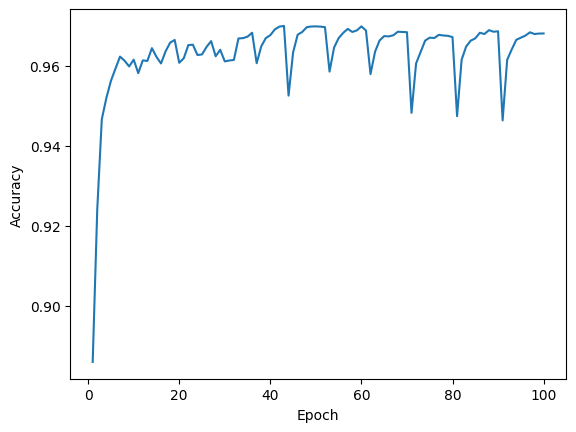

In [7]:
plt.plot([i+1 for i in range(len(acc_list))], acc_list)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

## 作业

- 电影评论情感分析 - [Kaggle](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data)